# A Pseudoproxy Experiment with GraphEM and pseudoPAGES2k

**Expected time to run through: TBD mins**

This tutorial demonstrates how to get a reconstruction using GraphEM, leveraging a simple pseudoproxy dataset generated from iCESM gridded, with the realistic spatial availability but full temporal availablity of the PAGES 2k version 2 dataset.
The pseudoproxies are generated based on the original iCESM simulated surface temperature (`tas`) plus white noise with `SNR=10`. While with LMR it is advantageous to have many redundant proxies (as long as they are unbiased, which is the case here), with GraphEM this can lead to some counter-intuitive difficulties, which we explain below.

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

## Data Preparation

In [2]:
# load a proxy database
job = cfr.ReconJob()
# job.proxydb = pd.read_pickle('./data/pseudoPAGES2k/pseudo.tpn_SNR10.pkl')
job.proxydb = pd.read_pickle('./data/pseudoPAGES2k/pseudo.tpn_SNR1.pkl')

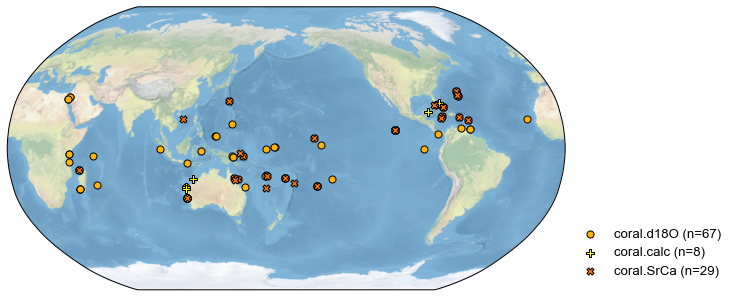

In [3]:
# filter the database
job.proxydb = job.proxydb.filter(by='ptype', keys='coral')
fig, ax = job.proxydb.plot()

In [4]:
job.proxydb = job.proxydb.center([1951, 1980])

Centering each of the ProxyRecord: 100%|█████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 3653.12it/s]


In [5]:
# load observations
job.load_clim(
    tag='obs',
    path_dict={
        'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
    },
    anom_period=(1951, 1980),
    verbose=True,
)

>>> job.configs["obs_path"] = {'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'}
>>> job.configs["obs_anom_period"] = (1951, 1980)
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> obs variables ['tas'] loaded
>>> job.obs created


In [6]:
# regrid and crop obs to make the problem size smaller
job.regrid_clim(tag='obs', nlat=42, nlon=63, verbose=True)
#job.regrid_clim(tag='obs', nlat=32, nlon=50, verbose=True)
job.crop_clim(tag='obs', lat_min=-25, lat_max=25, lon_min=120, lon_max=280, verbose=True)

>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...
>>> job.configs["prior_lat_min"] = -25
>>> job.configs["prior_lat_max"] = 25
>>> job.configs["prior_lon_min"] = 120
>>> job.configs["prior_lon_max"] = 280
>>> Processing tas ...


>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> job.obs updated


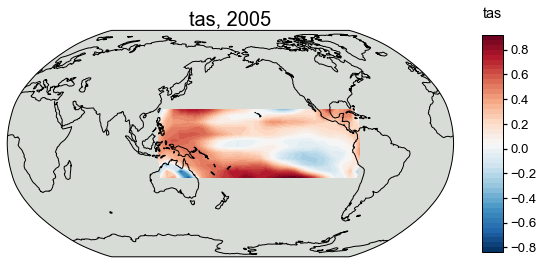

In [7]:
# annualize the observations
job.annualize_clim(tag='obs', verbose=True, months=list(range(1, 13)))
fig, ax = job.obs['tas'].plot(it=-1)

In [8]:
job.obs['tas'].da

<xarray.DataArray 'tas' (year: 1156, lat: 12, lon: 28)>
array([[[-1.43779302, -1.16293697, -1.01732908, ...,  0.39457998,
          0.52082612,  0.59373487],
        [-0.44181921, -0.51548275,  0.244261  , ...,  0.74474864,
          0.77145844,  0.68355714],
        [ 0.35079578,  0.32100882,  0.55368277, ...,  0.88217642,
          0.68757142,  0.31475473],
        ...,
        [ 0.72816369,  0.71887253,  0.54529944, ...,  0.20676015,
          0.30845679,  0.2907033 ],
        [ 1.10758701,  0.98782858,  1.00810014, ...,  0.09055938,
          0.18384386,  0.24694595],
        [ 1.31631178,  1.20505177,  1.04198581, ...,  0.14300547,
          0.29674634,  0.27620213]],

       [[-0.70474708, -0.01598469,  0.13178037, ..., -0.16622394,
         -0.03184134, -0.0226782 ],
        [-0.47576783, -0.55773132, -0.46185074, ..., -0.03219556,
          0.01012642,  0.01045555],
        [ 0.10615215, -0.04668079, -0.21236786, ...,  0.06428793,
         -0.00198371, -0.03837104],
...
        [ 0.25181528,  0.44903654,  0.61978375, ...,  0.31308888,
          0.36723991,  0.52567691],
        [ 0.04978446,  0.04787485,  0.22568625, ...,  0.45198041,
          0.4664865 ,  0.49749394],
        [ 0.10458478, -0.10605026, -0.21279729, ...,  0.54345012,
          0.54446683,  0.52080011]],

       [[ 0.0498074 ,  0.27873075,  0.39957376, ..., -0.03960866,
         -0.05272122,  0.16753688],
        [-0.37810031,  0.30122609, -0.0628949 , ..., -0.11026585,
          0.06519481,  0.26313251],
        [ 0.08783609, -0.448483  , -0.12010821, ..., -0.0352111 ,
          0.10163381,  0.12676614],
        ...,
        [ 0.09630422,  0.35422082,  0.39387372, ...,  0.24968949,
          0.3645677 ,  0.26936438],
        [-0.06625534,  0.26004941,  0.47504105, ...,  0.32676493,
          0.46907017,  0.4533393 ],
        [-0.19586628,  0.12946299,  0.54914526, ...,  0.38060853,
          0.41296104,  0.51346773]]])
Coordinates:
  * year     (year) int64 850 851 852 853 854 855 ... 2001 2002 2003 2004 2005
  * lon      (lon) float64 121.9 127.7 133.5 139.4 ... 261.3 267.1 272.9 278.7
  * lat      (lat) float64 -24.15 -19.76 -15.37 -10.98 ... 15.37 19.76 24.15

## Graph estimation

In GraphEM, the selection of the covariance model used for inferring missing values is based on a [graph](http://ir.hit.edu.cn/~jguo/docs/notes/report-in-princeton-research.pdf). 
Two types of graphs are supported:
1. Neighborhood graphs
2. Empirical graphs (graphical lasso)

Neighborhoood graphs as implemented here depend on a single parameter, the cutoff radius $R_c$. Every grid point or proxy within a great circle distance $R_c$ of a given grid point or proxy is declared a "neighbor", and the adjency matrix betweens those two points $(i,j)$ is $A_{ij} = A_{ji} = 1$ (it is 0 otherwise). The graphical lasso is a much more complicated, data-driven method that pulls conditional independence relations between variables from the data themselves, resulting in much more realistic covariance estimation that can detect coastlines, mountain ranges, currents or teleconnection patterns. While a neighborhood graph can always be specified, that is not the case for the graphical lasso: in our implementation it can only be applied to a gap-free data matrix. We recommend using a neighborhood graph $G_{R_c}$ with GraphEM to fill the gaps in the data matrix, then apply the graphical lasso to this clean matrix over the instrumental interval to estimate the graph $G_L$. Then, the GraphEM reconstruction can proceed with $G_L$.  

However, the difficulty is that both types of graph are controlled by a parameter whose value is uncertain. For neighborhood graphs,
an overly generous $R_c$ will lead to an under-regularized the model, with too many variables $p$ to estimate relative to the number of samples $n$ ; this will yield a numerically unstable solution that may fail to converge. On the other hand, if $R_c$ is too small, $A$ is too sparse, the model is over-regularized and the solution very damped. In the limit of $R_c=0$, $A$ is the identity matrix and the reconstruction is a flatline. 

What then is the optimal choice? Unfortunately, there is no theoretical criterion on how to choose an appropriate one. At a minimum, it should be larger than the largest spacing between nearby grid points (which tends to be largest at the equator). At most, it should be the circumference of the planet. That leaves quite some room in between. We will first carry out a preliminary reconstruction, before refining the choice of cutoff-radius via a process called [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

In the second section, we will do the same for the graphical lasso to choose an optimal combination of sparsity parameters. 


### 1a) Cross-validation

For this exercise we will use the same terminology as [scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html). Cross-validation is fundamental to model fitting, and is the most time-tested way to tune the parameters of a regression model such as GraphEM. Indeed, we can fit any graph to the data. The graph we want is the one that gives the "best" result. Best is in quotes because it may not always be possible to locate a unique optimum, so we may need to add other considerations. 

There are various [flavors of cross-validation](https://towardsdatascience.com/flavors-of-cross-validation-edfee24e8916) one can use. _k-fold cross-validation_ (typically with $k=5$) is a popular choice and what GraphEM implements (note: we could use the same approach to choose the localization radius in DA). This is what it looks like: the data are split in 5 groups. In each group, one withhold $1/k$ of the data for validation, using the remaining $(k-1)/k$ for calibration. 

In [9]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://scikit-learn.org/stable/_images/grid_search_cross_validation.png", width=600, height=400)

This process is repeated for various values of the tuning parameter (here, the cutoff radius) to construct a curve of some measure of expected prediction error (e.g. the mean square error, or MSE) vs the cutoff radius. That curve should have a U-shape, and the goal is to find the value of R that minimizes it. 
TO do so, we use the module `graphem_kcv()`, looping over a vector of cutoff radii for the neighborhood graph. One difficulty lies in specifying appropriate bounds for this search: numerically, the algorithm will always converge for a very small radius (though the solution will be overregularized, hence very damped in amplitude). At the other end of the spectrum, for large radii the solution is under-regularized, hence numerically unstable. The practical consequence is that GraphEM will fail to converge and throw many error messages along the way. Here we choose to search a space spanning 500 to 5000km in increments of 500km, but finding the upper bound can require some trial and error. 

>>> Processing fold 1:
>>> parameter = 500
Using specified graph
Running GraphEM:

Iter     dXmis     rdXmis

001     0.2174     4.1596
002     0.2011     0.8931
003     0.0940     0.5290
004     0.1269     0.5234
005     0.0711     0.2148
006     0.0293     0.0761


KeyboardInterrupt: 

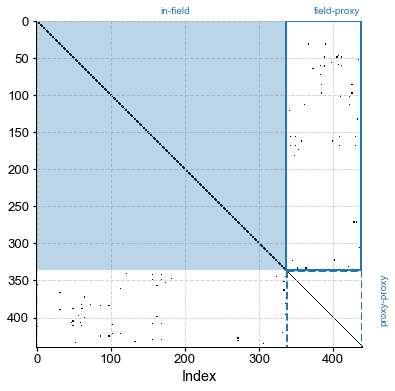

In [70]:
%%time
job_neigh = job.copy()

# cross validation test
cutoff_radii=np.arange(start=500,stop=5500,step=500)
kcv_stats = job_neigh.graphem_kcv(
    cv_time=np.arange(1850, 2001), stat='MSE', n_splits=5,
    ctrl_params=cutoff_radii, graph_type = 'neighborhood'
)

In [ ]:
fig, ax = plt.subplots()
ax.plot(cutoff_radii, kcv_stats.mean(axis=0), '-o')
ax.fill_between(cutoff_radii, kcv_stats.min(axis=0), kcv_stats.max(axis=0), alpha=0.3)
ax.set_xlabel('Cutoff radius')
ax.set_ylabel('MSE')
ax.set_title('K-fold Cross Validation')

In [ ]:
print("Minimum reached for R = {:d} km ".format(cutoff_radii[np.argmin(kcv_stats.mean(axis=0))]))

This shows the familiar U-shape mentioned above, and the cutoff radius that appears to minimize the MSE averaged over the 5 folds is  2000 km. However, you might notice that this minimum is rather shallow, so there is no strong reason to prefer this value over 1500 or 2500 km. However, there is an informal principle, known as the "1-SD rule", which states that in situations like these, one wants to select the least complex model whose MSE is within 1 standard deviation (fold-wise) of the global minimum. It looks from the plot that the least complex model (in this case, the one with sparsest graph, hence smallest cutoff radius), is the one corresponding to R = 1500 km. Indeed:

In [11]:
def one_sd_rule(objective_fun, param_vector):
    ''' One SD rule: selects the least complex model whose objective function (e.g. MSE) is 
    within 1 standard deviation (fold-wise) of the global minimum.
    
    Parameters
    ----------
    objective_fun : array-like (NumPy, Pandas or similar)
        values of the objective function, with the first dimension (0) assumed as the sample dimension
    param_vector :  array-like (NumPy, Pandas or similar)
        values of the control parameter used to compute the objective function. 
        
    Returns
    -------
    opt_param, the optimal parameter value
    '''    
    assert objective_fun.shape[1] == param_vector.shape[0], "param_vector has an incongruent dimension. See docstring"
    
    obj_mean = objective_fun.mean(axis=0)
    obj_min = obj_mean.min()
    i_min = np.argmin(obj_mean)
    sd = np.std(objective_fun,axis=0)[i_min]
    idx = np.where(obj_mean <= obj_min + sd)[0][0] # take first value
    opt_param = param_vector[idx]
    
    return opt_param 

In [ ]:
optimal_radius = one_sd_rule(kcv_stats,cutoff_radii)
print("The 1SD rule selects R = {:d} km ".format(optimal_radius))

In [71]:
optimal_radius = 1500 # shortcut

We must caution that the 1SD rule is a bit like statistical folklore: in wide use but without strong theoretical justification. Nevertheless, we have found it to yield fairly reliable results.


### 1b Reconstruction

Now that we have objectively chosen the graph, we can use the method `prep_graphem()` to weave everything into an object that the code can work with:

In [72]:
job_neigh.prep_graphem(
    recon_period=(1001, 2000),
    calib_period=(1850, 2000),
    verbose=True)

>>> job.configs["recon_period"] = (1001, 2000)
>>> job.configs["calib_period"] = (1850, 2000)
>>> job.graphem_params["recon_time"] created
>>> job.graphem_params["calib_time"] created
>>> job.graphem_params["field_obs"] created
>>> job.graphem_params["calib_idx"] created
>>> job.graphem_params["field"] created
>>> job.graphem_params["df_proxy"] created
>>> job.graphem_params["proxy"] created
>>> job.graphem_params["lonlat"] created


In [73]:
job_neigh.graphem_params['field']

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.70970161, 0.73450522, 0.30319882, ..., 0.34267614, 0.25509715,
        0.39273508],
       [0.57543254, 0.4847614 , 0.17716476, ..., 0.26505406, 0.25998264,
        0.37178005],
       [0.66133266, 0.97367383, 1.02246066, ..., 0.0466115 , 0.12031657,
        0.13679344]])

In [74]:
job_neigh.graphem_params['df_proxy']

,Ocn_065,Ocn_075,Ocn_078,Ocn_167,Ocn_091,Ocn_093,Ocn_096,Ocn_086,Ocn_101,Ocn_070,...,Ocn_090,Ocn_119,Ocn_109,Ocn_097,Ocn_159,Ocn_087,Ocn_153,Ocn_169,Ocn_071,Ocn_072
1001,-0.029472,-0.079615,-0.164675,1.136972,-0.170487,-0.068706,0.001636,0.265989,0.029111,-0.060844,...,-0.016145,-0.023198,0.026751,-0.290637,-0.036539,-0.121053,-0.043656,-0.082111,-0.135477,-0.098504
1002,-0.021149,-0.096633,-0.120066,0.211940,-0.247028,-0.053001,0.014841,-0.099275,-0.163322,-0.069958,...,-0.651486,-0.012971,-0.026148,-0.209297,0.015105,0.072593,-0.088941,0.132871,-0.066113,-0.025315
1003,0.017044,0.177338,0.067678,-0.201700,0.062675,0.001354,0.009087,0.010825,0.001898,-0.107092,...,-0.184804,-0.250715,-0.002932,0.198525,-0.043845,0.095773,0.076952,0.905556,-0.117440,0.068865
1004,-0.072836,0.050557,-0.047072,-0.452527,-0.251116,0.059971,0.044815,0.041075,0.088916,-0.177990,...,-0.192031,-0.190020,0.028051,0.091881,-0.070303,0.038124,-0.014257,0.104113,0.022662,-0.027317
1005,0.036772,-0.181680,0.057200,-0.042987,0.042531,0.017662,-0.011964,-0.014553,-0.036732,0.045409,...,0.136227,-0.204292,-0.041819,-0.188765,-0.051463,-0.252486,0.095564,-0.581049,-0.271404,0.033542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,0.084822,0.202729,0.237921,-0.680074,-0.085530,0.000029,-0.077145,-0.059342,0.055956,0.283716,...,0.096534,0.287984,-0.026136,0.299611,0.096891,-0.002844,0.072604,0.326452,-0.042538,0.036153
1997,0.062888,0.627227,0.257458,0.895186,0.445891,0.036438,0.011253,0.408338,0.012960,0.111141,...,0.227277,-0.044239,0.068132,0.145206,-0.044438,-0.251896,0.106174,0.265856,-0.095977,-0.026760
1998,0.081860,0.218101,0.092819,-2.040758,0.530765,0.046501,0.162912,0.195244,0.074552,0.075628,...,0.248375,0.137352,0.128556,0.252945,0.006005,0.192609,0.046924,0.344340,-0.018421,0.002962
1999,0.053651,-0.316188,0.131558,0.182525,-0.043207,0.080396,-0.022788,0.234294,0.170416,0.076104,...,0.071616,0.122794,-0.010480,0.271125,0.021608,-0.088485,-0.014478,1.077392,0.440469,0.000934


In [75]:
G_R = cfr.graphem.Graph(
    job_neigh.graphem_params['lonlat'],
    job_neigh.graphem_params['field'],
    job_neigh.graphem_params['proxy'])

Let us define a neighborhood graph by including only points within a cutoff_radius $R$ of each grid point or proxy locale. The location takes a bit of time the first time around as the matrix of mutual great- circle distances needs to be computed: 

In [76]:
G_R.neigh_adj(cutoff_radius=optimal_radius)

Next we plot the temperature neighbors of a particular proxy to show what happened:

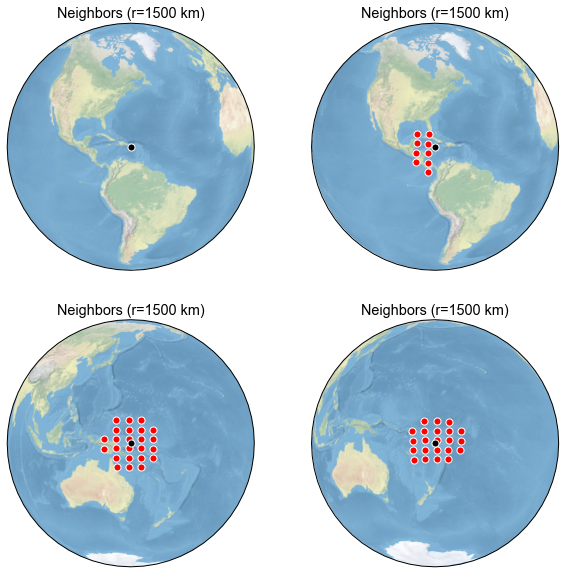

In [22]:
n_proxy = job_neigh.graphem_params['df_proxy'].shape[1]
idcs = np.random.randint(0,n_proxy,4) # randomly pick indices
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.2, hspace=0.2)
ax = {}
for i, idx in enumerate(idcs):
    fig_map, ax_map = G_R.plot_neighbors(idx)
    cfr.closefig(fig_map)  # mute the figure
    ax[idx] = fig.add_subplot(gs[i], projection=ax_map.projection)
    G_R.plot_neighbors(idx,ax=ax[idx])

This, however, does not tell us the degree to which this proxy correlates to temperature at nerby grid points over the instrumental era. To do that, we use:

(<Figure size 360x360 with 2 Axes>,
 <GeoAxesSubplot:title={'center':'Neighbors (r=1500 km)'}>)

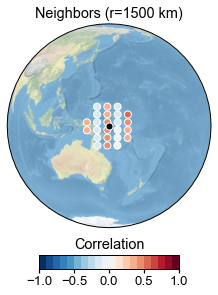

In [24]:
G_R.plot_neighbors_corr(idcs[2])

This can be instructive for small proxy networks, or for debugging purposes. For instance, we notice one proxy in the tropical Atlantic that has zero neighbors, because the grid is restricted to the Pacific far beyond the cutoff radius. 

For a bird's eye view of the graph, we instead plot the adjacency matrix itself (dots indicate neighbors):

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:xlabel='Index'>)

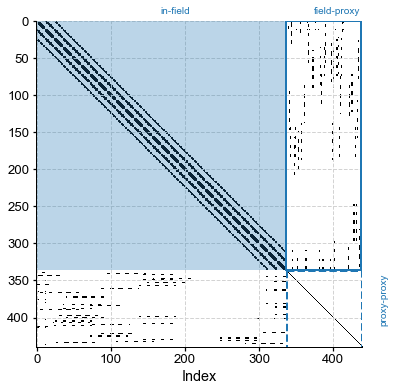

In [25]:
G_R.plot_adj()

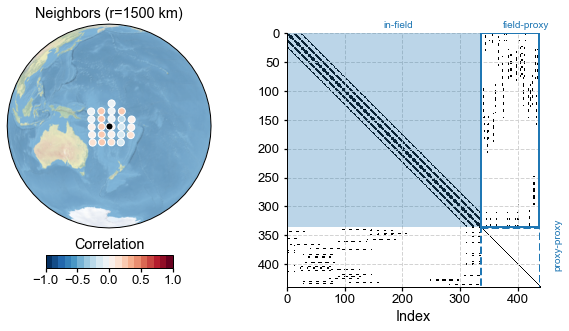

In [26]:
# an example of passing axes with map projections

# we need to first make a plot with map projections to get the specific projection,
# otherwise we have ot set it manually later
i = 20 # proxy index
fig_map, ax_map = G_R.plot_neighbors(i)
cfr.closefig(fig_map)  # mute the figure

# now we make a new figure to include subplots generated by
# `plot_neighbors()` or `plot_neighbors_corr()` and `plot_adj()`
fig = plt.figure(figsize=[10, 5])
ax = {}
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.2, hspace=0.2)
# the 1st subplot will use the exact projection we had earlier
ax['map'] = fig.add_subplot(gs[0], projection=ax_map.projection)
ax['adj'] = fig.add_subplot(gs[1])
# we may call `plot_neighbors_corr()` since it has the same projection
ax['map'] = G_R.plot_neighbors_corr(i, ax=ax['map'])
ax['adj'] = G_R.plot_adj(ax=ax['adj'])

By construction, proxies are assumed conditionally independent of each other, so the proxy-proxy part of the adjacency matrix is diagonal. The climate-climate is block-diagonal, reflecting the fact that nearby indices tend to reflect nearby gridpoints, and nearby gridpoints generally have similar climates*.  There are discontinuities that happen when cycling through longitudes (0 --> 360 back to 0), which show up as abrupt breaks in the graph. The climate-proxy part is less regular, reflecting the fact that proxy locations are not uniformly spaced (unlike the grid points of the climate field). Notice how the overall matrix is very __sparse__: only a handful of of entries are non-zero (white is the main color on this plot). To be more precise, the `sparsity` property quantifies the fraction of non-zero entries:

In [27]:
G_R.sparsity

[0.05653873489694385, 0.03345352564102564, 0.0]

We see that only a few % of the graph of the climate field and of the climate-proxy graph, have non-zero entries (the diagonal is excluded from this calculation, because a random variable is always conditionally dependent on itself). With this convention, and assuming that proxies are independent of each other (corals from two different islands don't affect each other's growth, given the climate). then the proxy-proxy part of the adjacency matrix is diagonal and has a sparsity of 0. This graph has achieved what we wanted: reducing the number of parameters to be estimated while computing the covariance matrix, which otherwise would be ill-conditioned. 

## running GraphEM

In [28]:
job_neigh.run_graphem?

Signature:
job.run_graphem(
    save_recon=True,
    save_dirpath=None,
    load_precalc_solver=False,
    solver_save_path=None,
    compress_params=None,
    verbose=False,
    **fit_kws,
)
Docstring:
Run the GraphEM solver, essentially the :py:meth: `GraphEM.solver.GraphEM.fit` method

Note that the arguments for :py:meth: `GraphEM.solver.GraphEM.fit` can be appended in the
argument list of this function directly. For instance, to pass a pre-calculated graph, use
`estimate_graph=False` and `graph=g.adj`, where `g` is the :py:`Graph` object.

Args:
    save_dirpath (str): the path to save the related results
    load_precalculated (bool, optional): load the precalculated `Graph` object. Defaults to False.
    verbose (bool, optional): print verbose information. Defaults to False.
    fit_kws (dict): the arguments for :py:meth: `GraphEM.solver.GraphEM.fit`

See also:
    cfr.graphem.solver.GraphEM.fit : fitting the GraphEM method
File:      ~/Documents/GitHub/cfr/cfr/reconjob.py
Type:

In [77]:
%%time
job_neigh.run_graphem(
    save_recon=True,
    save_dirpath='./results/graphem-ppe-pages2k',
    verbose=True,
    estimate_graph=False,
    graph=G_R.adj,
)

>>> job.configs["save_dirpath"] = ./results/graphem-ppe-pages2k
Using specified graph
Running GraphEM:

Iter     dXmis     rdXmis

001     0.0498     0.7232
002     0.1861     2.1704
003     0.0904     0.3866
004     0.0495     0.1568
005     0.0325     0.0928
006     0.0238     0.0639
007     0.0201     0.0516
008     0.0177     0.0439
009     0.0163     0.0393
010     0.0147     0.0346
011     0.0138     0.0319
012     0.0125     0.0284
013     0.0116     0.0259
014     0.0112     0.0248
015     0.0103     0.0225
016     0.0102     0.0221
017     0.0094     0.0201
018     0.0088     0.0188
019     0.0089     0.0190
020     0.0082     0.0173
021     0.0077     0.0161
022     0.0072     0.0152
023     0.0075     0.0157
024     0.0069     0.0143
025     0.0064     0.0133
026     0.0060     0.0124
027     0.0057     0.0117
028     0.0053     0.0110
029     0.0051     0.0104
030     0.0048     0.0099
031     0.0054     0.0111
032     0.0042     0.0086
033     0.0048     0.0098
034     0.0

### 1.c Validation

Now we have a reconstruction ; let's see how well it compares to the target:

In [78]:
neigh_res = cfr.ReconRes('./results/graphem-ppe-pages2k', verbose=True)

>>> res.paths:
['./results/graphem-ppe-pages2k/job_r01_recon.nc']


In [79]:
neigh_res.load(['nino3.4', 'tas'], verbose=True)

>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created
>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created


In [80]:
mask = (job_neigh.obs['tas'].time >= 1001) & (job_neigh.obs['tas'].time <= 2000)
target = job_neigh.obs['tas'].da.values[mask]
print(np.shape(target))

(1000, 12, 28)


#### Spatially-averaged Statistics

In [81]:
nt = np.size(neigh_res.recons['tas'].time)
field_r = job_neigh.graphem_solver.field_r
inst    = job_neigh.graphem_params['calib_idx']
V = cfr.graphem.solver.verif_stats(field_r, target.reshape((nt, -1)), inst)
print(V)

Mean MSE = 0.1018, Mean RE = 0.5506, Mean CE = 0.4918, Mean R2 = 0.5691


#### Map of CE

In [82]:
ce = cfr.utils.coefficient_efficiency(target, neigh_res.recons['tas'].da.values)
print(np.shape(ce))

(12, 28)


Text(0.5, 1.0, 'CE')

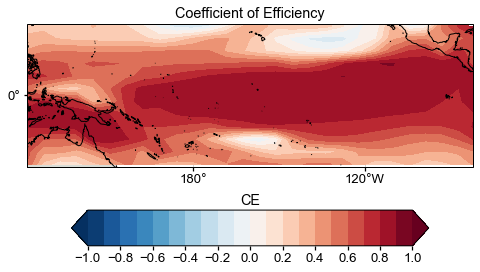

In [83]:
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

fig = plt.figure(figsize=[8, 8])
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title('Coefficient of Efficiency')
# latlon_range = [0, 360, -90, 90]
latlon_range = [122, 278, -25, 25]
transform=ccrs.PlateCarree()

ax.set_extent(latlon_range, crs=transform)
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

lon_ticks=[60, 120, 180, 240, 300]
lat_ticks=[-90, -45, 0, 45, 90]
lon_ticks = np.array(lon_ticks)
lat_ticks = np.array(lat_ticks)
lon_min, lon_max, lat_min, lat_max = latlon_range
mask_lon = (lon_ticks >= lon_min) & (lon_ticks <= lon_max)
mask_lat = (lat_ticks >= lat_min) & (lat_ticks <= lat_max)
ax.set_xticks(lon_ticks[mask_lon], crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks[mask_lat], crs=ccrs.PlateCarree())

levels = np.linspace(-1, 1, 21)
cbar_labels = np.linspace(-1, 1, 11)
cbar_title = 'CE'
extend = 'both'
cmap = 'RdBu_r'
cbar_pad=0.1
cbar_orientation='horizontal'
cbar_aspect=10
cbar_fraction=0.35
cbar_shrink=0.8
font_scale=1.5
land_color=sns.xkcd_rgb['light grey']
ocean_color=sns.xkcd_rgb['white']
        
ax.add_feature(cfeature.LAND, facecolor=land_color, edgecolor=land_color)
ax.add_feature(cfeature.OCEAN, facecolor=ocean_color, edgecolor=ocean_color)
ax.coastlines()
im = ax.contourf(job_neigh.obs['tas'].lon, job_neigh.obs['tas'].lat, ce, levels, transform=transform, cmap=cmap, extend=extend)
cbar = fig.colorbar(
    im, ax=ax, orientation=cbar_orientation, pad=cbar_pad, aspect=cbar_aspect,
    fraction=cbar_fraction, shrink=cbar_shrink)
cbar.set_ticks(cbar_labels)
cbar.ax.set_title(cbar_title)

### Timeseries comparison

In [84]:
da = cfr.utils.geo_mean(job_neigh.obs['tas'].da, lat_min=-5, lat_max=5, lon_min=np.mod(-170, 360), lon_max=np.mod(-120, 360))
ref_time = da.year.values
ref_value = da.values
ref_name = 'truth'

(1000.0, 2000.0)

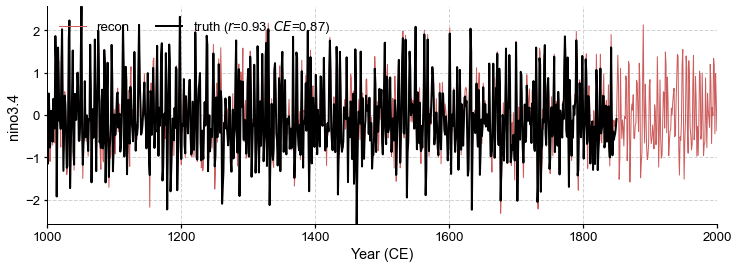

In [85]:
fig, ax = neigh_res.recons['nino3.4'].validate(
    ref_time, ref_value, ref_name, valid_period=[1001, 1850]).plot()
ax.set_xlim(1000, 2000)

In [41]:
lats, lons, colors, markers, markersizes = {}, {}, {}, {}, {}
for pobj in job.proxydb:
    pid = pobj.pid
    lats[pid] = pobj.lat
    lons[pid] = pobj.lon
    colors[pid] = cfr.visual.STYLE.colors_dict[pobj.ptype]
    markers[pid] = cfr.visual.STYLE.markers_dict[pobj.ptype]
    markersizes[pid] = 200

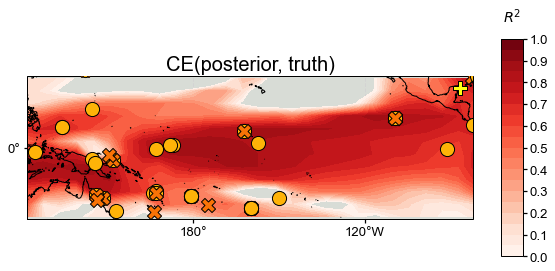

In [86]:
stat = 'CE'  # Bug: colorbad shows R2 instead of CE
neigh_valid = neigh_res.recons['tas'].validate(
    job.obs['tas'], stat=stat,
    valid_period=(1750, 1850),
    interp_direction='from-ref',
)
fig, ax = neigh_valid.plot(
    title=f'{stat}(posterior, truth)',
    projection='PlateCarree',
    latlon_range=(-25, 25, 122, 278),
    site_lats=lats, site_lons=lons,
    site_markersize=markersizes, site_marker=markers,
    site_color=colors,
    **valid_fd.plot_kwargs)

We see that skill is very high in most regions, particularly in the vicinity of proxy sites, though the SPCZ is less well captured than the central equatorial Pacific, for instance.


## 2. Graphical Lasso

The graphical LASSO [(Friedman et al, 2008)](https://doi.org/10.1093/biostatistics/kxm045) is a convex optimization algorithm that uses least angles regression to obtain the adjacency matrix. 

In GraphEM, GLASSO is controlled by 2 sparsity parameters:
- target_FF: Target sparsity of the in-field part of the graph (%)
- target_FP: Target sparsity of the field/proxy part of the graph (%)

As before, the sparser the graph, the fewer variables are estimated, and the better conditioned the covariance matrices are, but a good compromise must be found so as not to over-regularize. As a rule of thumb, target sparsities should be on the order of a few % (1-10) to give reasonable results. Let us first look at the case where these numbers are 3% and 3%, respectively:

### 2a. Greedy Search

The code uses a greedy algorithm to obtain a graph whose sparsity approaches that of the target:

In [43]:
G_L = cfr.graphem.Graph(
    lonlat = job.graphem_params['lonlat'],
    field = field_r[inst],
    proxy = job.graphem_params['proxy'][inst,:])

In [50]:
G_L.glasso_adj(target_FF=3,target_FP=4)

Solving graphical LASSO using greedy search
Iter    FF      FP      PP

001   0.000   0.000   0.000
002   0.867   0.000   0.000
003   2.347   0.000   0.000
004   3.746   0.000   0.000
005   3.746   0.000   0.000
006   3.746   0.000   0.000
007   3.746   0.000   0.000
008   3.746   0.000   0.000
009   3.746   0.000   0.000
010   3.746   0.103   0.000
011   3.746   0.358   0.000
012   3.730   0.793   0.000
013   3.669   1.540   0.000
014   3.502   2.802   0.000
015   3.129   4.006   0.000


In [51]:
G_L.sparsity

array([3.5021322 , 2.80162546, 0.        ])

Text(0.5, 1.0, 'Tentative GLASSO graph, sp = 3.50 %')

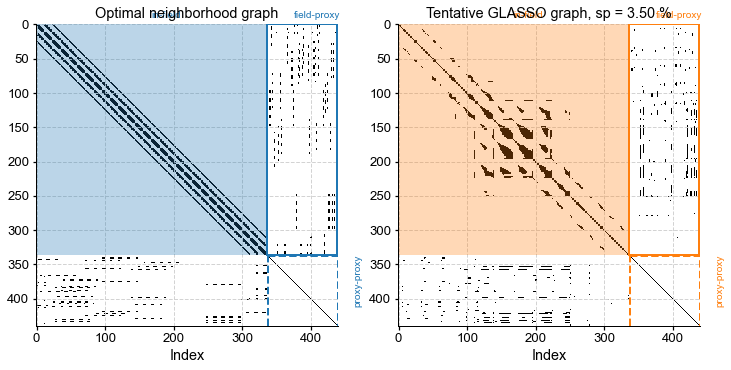

In [46]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
G_R.plot_adj(ax=ax[0],clr='C0')
ax[0].set_title("Optimal neighborhood graph") # need to fix vertical spacing
G_L.plot_adj(ax=ax[1],clr='C1')
ax[1].set_title("Tentative GLASSO graph, sp = {:3.2f} %".format(G_L.sparsity[0],G_L.sparsity[1])) 

Comparing with the previously obtained neighborhood graph, we see that GLASSO, for this particular choice of parameters, led to a similar block-diagonal pattern for the in-field part of the matrix, however the extent of these blocks varies from point to point. This is an indication of anisotopy: the algorithm is able to detect coherent structures that may be irregular in latitude and longitude. Let's look at those neighbors:

Text(0.5, 1.0, 'Number of neighbors for each proxy')

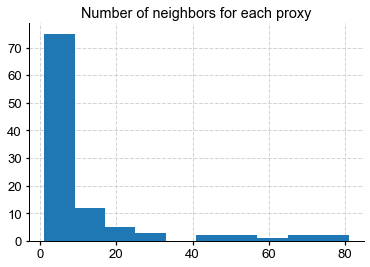

In [47]:
n_grid = field_r.shape[1]
n_neighbors = np.sum(G_L.adj[n_grid:,:],axis=1)
plt.hist(n_neighbors)
plt.title("Number of neighbors for each proxy")

In [ ]:
rich_proxies = np.where(n_neighbors>20)[0]

four_idcs = np.random.randint(0,len(rich_proxies),4)
glasso_idcs = rich_proxies[four_idcs]
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.2, hspace=0.2)
ax = {}
for i, idx in enumerate(glasso_idcs):
    fig_map, ax_map = G_L.plot_neighbors(idx)
    cfr.closefig(fig_map)  # mute the figure
    ax[idx] = fig.add_subplot(gs[i], projection=ax_map.projection)
    G_L.plot_neighbors(idx,ax=ax[idx])

We see that some proxies are deemed important by GLASSO, which finds them many neighbors in the climate field. Put another way, those proxies will inform the reconstruction of the climate field at the location of these red dots, though not in equal amount (they will be weighted by covariances, not shown here). 

Now, as before, we must optimize to find parameters that maxmimize reconstruction skill.

### 2b. Cross-Validation

In [53]:
%%time

# cross validation test
sp_vec = np.arange(1.0,9.0)
kcv_stats = job.graphem_kcv(
    cv_time = np.arange(1850, 2001), stat='MSE', n_splits=5,
    ctrl_params = sp_vec, graph_type = 'glasso'
)

>>> Processing fold 1:
>>> parameter = 1.0
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/julieneg/opt/miniconda3/envs/cfr-env/lib/python3.9/site-packages/IPython/core/magics/execution.py", line 1316, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 3, in <module>
  File "/Users/julieneg/Documents/GitHub/cfr/cfr/reconjob.py", line 860, in graphem_kcv
    g_cv.glasso_adj(target_FF=param, target_FP=param)
  File "/Users/julieneg/Documents/GitHub/cfr/cfr/graphem/graph.py", line 135, in glasso_adj
    [adj, sp] = graph_greedy_search(self.field, self.proxy, target_FF, target_FP)
ValueError: too many values to unpack (expected 2)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/julieneg/opt/miniconda3/envs/cfr-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 1993, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/julieneg/opt/miniconda3/envs/cfr-env/lib/python3.9/site-packages/IPython/cor

### 2c. Reconstruction 

In [55]:
job_glasso = job.copy()
job_glasso.run_graphem(
    save_recon=True,
    save_dirpath='./results/graphem-ppe-pages2k',
    verbose=True,
    estimate_graph=False,
    graph=G_L.adj,
)

>>> job.configs["save_dirpath"] = ./results/graphem-ppe-pages2k
Using specified graph
Running GraphEM:

Iter     dXmis     rdXmis

001     0.0498     0.7232
002     0.2066     2.4095
003     0.0601     0.2358
004     0.0301     0.0989
005     0.0226     0.0696
006     0.0187     0.0552
007     0.0160     0.0459
008     0.0141     0.0393
009     0.0125     0.0340
010     0.0111     0.0297
011     0.0099     0.0262
012     0.0090     0.0235
013     0.0086     0.0222
014     0.0081     0.0207
015     0.0081     0.0206
016     0.0078     0.0197
017     0.0081     0.0204
018     0.0079     0.0198
019     0.0079     0.0195
020     0.0078     0.0193
021     0.0082     0.0202
022     0.0080     0.0194
023     0.0077     0.0187
024     0.0078     0.0189
025     0.0073     0.0175
026     0.0068     0.0163
027     0.0063     0.0151
028     0.0058     0.0139
029     0.0054     0.0127
030     0.0052     0.0123
031     0.0047     0.0110
032     0.0042     0.0099
033     0.0039     0.0091
034     0.0

In [56]:
glasso_res = cfr.ReconRes('./results/graphem-ppe-pages2k', verbose=True)

>>> res.paths:
['./results/graphem-ppe-pages2k/job_r01_recon.nc']


In [57]:
glasso_res.load(['nino3.4', 'tas'], verbose=True)

>>> ReconRes.recons["nino3.4"] created
>>> ReconRes.da["nino3.4"] created
>>> ReconRes.recons["tas"] created
>>> ReconRes.da["tas"] created


#### Spatially-averaged Statistics

In [58]:
field_r = job_glasso.graphem_solver.field_r
inst    = job_glasso.graphem_params['calib_idx']
V = cfr.graphem.solver.verif_stats(field_r, target.reshape((nt, -1)), inst)
print(V)

Mean MSE = 0.0953, Mean RE = 0.5975, Mean CE = 0.5423, Mean R2 = nan


/Users/julieneg/opt/miniconda3/envs/cfr-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/julieneg/opt/miniconda3/envs/cfr-env/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


#### Map of CE

In [60]:
ce = cfr.utils.coefficient_efficiency(target, glasso_res.recons['tas'].da.values)

Text(0.5, 1.0, 'CE')

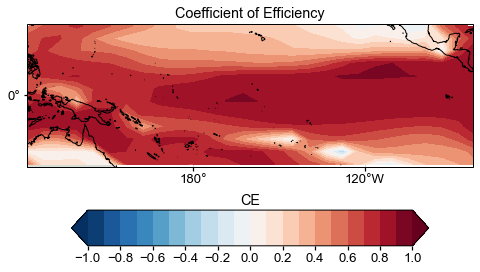

In [61]:
fig = plt.figure(figsize=[8, 8])
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_title('Coefficient of Efficiency')
# latlon_range = [0, 360, -90, 90]
latlon_range = [122, 278, -25, 25]
transform=ccrs.PlateCarree()

ax.set_extent(latlon_range, crs=transform)
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

lon_ticks=[60, 120, 180, 240, 300]
lat_ticks=[-90, -45, 0, 45, 90]
lon_ticks = np.array(lon_ticks)
lat_ticks = np.array(lat_ticks)
lon_min, lon_max, lat_min, lat_max = latlon_range
mask_lon = (lon_ticks >= lon_min) & (lon_ticks <= lon_max)
mask_lat = (lat_ticks >= lat_min) & (lat_ticks <= lat_max)
ax.set_xticks(lon_ticks[mask_lon], crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks[mask_lat], crs=ccrs.PlateCarree())

levels = np.linspace(-1, 1, 21)
cbar_labels = np.linspace(-1, 1, 11)
cbar_title = 'CE'
extend = 'both'
cmap = 'RdBu_r'
cbar_pad=0.1
cbar_orientation='horizontal'
cbar_aspect=10
cbar_fraction=0.35
cbar_shrink=0.8
font_scale=1.5
land_color=sns.xkcd_rgb['light grey']
ocean_color=sns.xkcd_rgb['white']
        
ax.add_feature(cfeature.LAND, facecolor=land_color, edgecolor=land_color)
ax.add_feature(cfeature.OCEAN, facecolor=ocean_color, edgecolor=ocean_color)
ax.coastlines()
im = ax.contourf(job.obs['tas'].lon, job.obs['tas'].lat, ce, levels, transform=transform, cmap=cmap, extend=extend)
cbar = fig.colorbar(
    im, ax=ax, orientation=cbar_orientation, pad=cbar_pad, aspect=cbar_aspect,
    fraction=cbar_fraction, shrink=cbar_shrink)
cbar.set_ticks(cbar_labels)
cbar.ax.set_title(cbar_title)

### Timeseries comparison

In [62]:
da = cfr.utils.geo_mean(job_glasso.obs['tas'].da, lat_min=-5, lat_max=5, lon_min=np.mod(-170, 360), lon_max=np.mod(-120, 360))
ref_time = da.year.values
ref_value = da.values
ref_name = 'truth'

(1000.0, 2000.0)

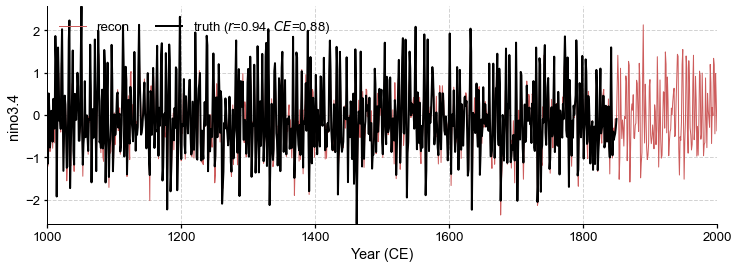

In [64]:
fig, ax = glasso_res.recons['nino3.4'].validate(
    ref_time, ref_value, ref_name, valid_period=[1001, 1850]).plot()
ax.set_xlim(1000, 2000)

In [41]:
lats, lons, colors, markers, markersizes = {}, {}, {}, {}, {}
for pobj in job.proxydb:
    pid = pobj.pid
    lats[pid] = pobj.lat
    lons[pid] = pobj.lon
    colors[pid] = cfr.visual.STYLE.colors_dict[pobj.ptype]
    markers[pid] = cfr.visual.STYLE.markers_dict[pobj.ptype]
    markersizes[pid] = 200

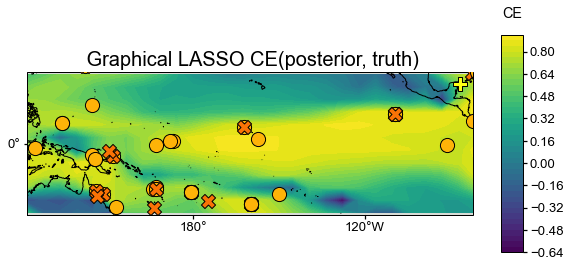

In [90]:
stat = 'CE'
glasso_valid = glasso_res.recons['tas'].validate(
    job.obs['tas'], stat=stat,
    valid_period=(1750, 1850),
    interp_direction='from-ref',
)
fig, ax = glasso_valid.plot(
    title=f' Graphical LASSO {stat}(posterior, truth)',
    projection='PlateCarree',
    latlon_range=(-25, 25, 122, 278),
    site_lats=lats, site_lons=lons,
    site_markersize=markersizes, site_marker=markers,
    site_color=colors)

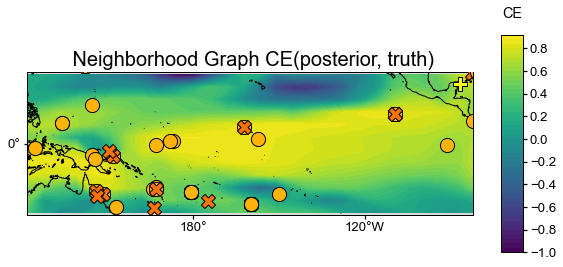

In [89]:
fig, ax = neigh_valid.plot(
    title=f' Neighborhood Graph {stat}(posterior, truth)',
    projection='PlateCarree',
    latlon_range=(-25, 25, 122, 278),
    site_lats=lats, site_lons=lons,
    site_markersize=markersizes, site_marker=markers,
    site_color=colors)

How to easily compare two reconstructions pairwise? It would be nice to have a function called `compare` that takes neigh_res and glasso_res and compares the maps, timeseries, and tables of various metrics (R2, CE, etc.)